## E-MINI S&P 500 OPTIONS

- `Globex`: Globex is an electronic trading platform—the first of its kind when it launched in 1992—used for derivatives like futures, options, and commodity contracts across a wide range of asset classes. 

- `Last.Trade.Date`: The last trading day for an option is the day before the expiration date.

- `Open.interest`: indicates the total number of option contracts that are currently out there. When options have a significant open interest, it means there are a large number of buyers and sellers out there.

- `CONTRACT UNIT`: $50 x Agreed E-Mini Futures Price

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import date
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import BatchNormalization

np.set_printoptions(precision = 3, suppress = True)

In [10]:
EZ = pd.read_excel("EZ.xlsx")
EZ.head()

,Put.Call,Strike.Price,Contract.Month,Settlement,Open.Interest,Delta,Implied.Volatility,Last.Trade.Date
0,C,100,3,3802.9,0,1.0,0.922341,20210319
1,C,1000,3,2902.9,11,1.0,0.922341,20210319
2,C,1500,3,2403.0,20,1.0,0.906427,20210319
3,C,1550,3,2353.0,1,1.0,0.876522,20210319
4,C,1800,3,2103.1,7,1.0,0.797028,20210319


### Linear homogenous in BS model

Underlying asset price:
$$\color{dodgerblue}{S_{new} = \frac{S * 100}{S}}$$

Strike price:
$$\color{dodgerblue}{K_{new} = \frac{K * 100}{K}}$$

Call price:
$$\color{dodgerblue}{C(S_{new}, K_{new}) = \frac{C(S, K) * 100}{S}}$$

In [11]:
assetPrice = 3900
EZ['Strike.Price'] = (EZ['Strike.Price'].values * 100) / assetPrice
EZ['Settlement'] = (EZ['Settlement'].values * 100) / assetPrice

In [12]:
# Calculate the time to maturity
T = np.zeros(EZ.shape[0])
start_date = date(2021, 2, 10)
for i in range(EZ.shape[0]):
    if EZ['Last.Trade.Date'][i] == 20210319:
        T[i] = (date(2021, 3, 19) - start_date).days
    elif EZ['Last.Trade.Date'][i] == 20210618:
        T[i] = (date(2021, 6, 18) - start_date).days
    elif EZ['Last.Trade.Date'][i] == 20210917:
        T[i] = (date(2021, 9, 17) - start_date).days
    elif EZ['Last.Trade.Date'][i] == 20211217:
        T[i] = (date(2021, 12, 17) - start_date).days

# Change the unit to be year
T /= 365
assert np.sum(T == 0) == 0, 'Time should be positive'

df = EZ[['Put.Call', 'Strike.Price', 'Settlement', 'Implied.Volatility']].copy()
df['Time.to.maturity'] = T
df.head()

,Put.Call,Strike.Price,Settlement,Implied.Volatility,Time.to.maturity
0,C,2.564103,97.510256,0.922341,0.10137
1,C,25.641026,74.433333,0.922341,0.10137
2,C,38.461538,61.615385,0.906427,0.10137
3,C,39.743590,60.333333,0.876522,0.10137
4,C,46.153846,53.925641,0.797028,0.10137


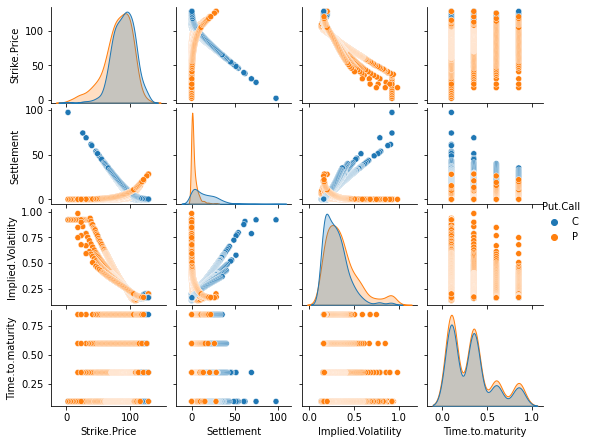

In [13]:
# Pairs plot
g = sns.pairplot(df, hue = 'Put.Call')
g.fig.set_size_inches(8,6)
plt.show()

In [17]:
df_Call = df[df['Put.Call'] == 'C']
df_Call = df_Call.drop(['Put.Call'], axis = 1)
df_Call.head()

,Strike.Price,Settlement,Implied.Volatility,Time.to.maturity
0,2.564103,97.510256,0.922341,0.10137
1,25.641026,74.433333,0.922341,0.10137
2,38.461538,61.615385,0.906427,0.10137
3,39.743590,60.333333,0.876522,0.10137
4,46.153846,53.925641,0.797028,0.10137


In [18]:
df_Call.describe()

,Strike.Price,Settlement,Implied.Volatility,Time.to.maturity
count,470.000000,470.000000,470.000000,470.000000
mean,89.381615,14.700537,0.298491,0.319918
std,17.302600,13.512668,0.134437,0.236168
min,2.564103,0.001282,0.135391,0.101370
25%,77.500000,3.262821,0.193405,0.101370
50%,90.384615,11.747436,0.273854,0.350685
75%,101.794872,23.246154,0.363972,0.350685
max,128.205128,97.510256,0.922341,0.849315


In [26]:
df_Call['Time.to.maturity'].value_counts()

0.101370    198
0.350685    177
0.600000     50
0.849315     45
Name: Time.to.maturity, dtype: int64

### Moneyness

In the paper 'DeepOption: A novel option pricing framework based on deep learning with fused distilled data from multiple parametric methods', the dividing criteria for the moneyness are ITM when S/K > 1.05, ATM when 1.05 ≥ S/K ≥ 0.97, and OTM when 0.97 > S/K for the call option.

Then,

- ITM: K/S < 0.952
- ATM: 0.952 ≤ K/S ≤ 1.03
- OTM: K/S > 1.03

In [42]:
ITM_idx = df_Call['Strike.Price'] < 95.2
ATM_idx = np.logical_and(df_Call['Strike.Price'] < 103, df_Call['Strike.Price'] >= 95.2)
OTM_idx = df_Call['Strike.Price'] > 103
print('The number of ITM Call options is', np.sum(ITM_idx))
print('The number of ATM Call options is', np.sum(ATM_idx))
print('The number of OTM Call options is', np.sum(OTM_idx))

The number of ITM Call options is 286
The number of ATM Call options is 77
The number of OTM Call options is 107


In [27]:
path = "/Users/gaojinglun/Desktop/RSG/ANN_call_Volatility_withLR0.01"
ANN_call = keras.models.load_model(path)

In [32]:
pickle_in = open("scalerX.pickle","rb")
scalerX = pickle.load(pickle_in)
pickle_in = open("scalery.pickle","rb")
scalery = pickle.load(pickle_in)

In [38]:
X = df_Call[['Strike.Price', 'Time.to.maturity', 'Settlement']]
y = df_Call['Implied.Volatility']
testX = pd.DataFrame(scalerX.transform(X), columns = X.columns.values) 
testY = scalery.transform(y.values.reshape(-1, 1))

In [66]:
pred = ANN_call.predict(testX)
print('In the money r-squared', r2_score(testY[ITM_idx], pred[ITM_idx]))
print('At the money r-squared', r2_score(testY[ATM_idx], pred[ATM_idx]))
print('Out of the money r-squared', r2_score(testY[OTM_idx], pred[OTM_idx]))

In the money r-squared -0.48353980591262125
At the money r-squared 0.14282024878707067
Out of the money r-squared -2.368155380173749


In [64]:
r2_score(testY, ANN_call.predict(testX))

0.23589760314500252